In [5]:
import matplotlib.pyplot as plt
import torch.utils.data
import torch.nn
from random import randrange
import os
import math
os.environ["WDS_VERBOSE_CACHE"] = "1"
os.environ["GOPEN_VERBOSE"] = "0"

import webdataset as wds

from utils import get_tar_files, show_img_for

ALL_DATA_DIR = "/cluster/work/lawecon_repo/gravestones/shards/images"

## 1. Load Data

In [2]:
dataset_dir = "transfer_2025-05-18_084428"

# get all tar files from the dataset directory
tar_files = get_tar_files(os.path.join(ALL_DATA_DIR, dataset_dir))
print(f"Found {len(tar_files)} tar files.")

# use the first tar file for testing
tar_file = tar_files[0]

dataset = (
    wds.WebDataset(tar_file)
    .decode("pil")
    .to_tuple("jpg;png")
)

assert isinstance(dataset, torch.utils.data.IterableDataset)
print(f"Dataset loaded from tar file: {tar_file}")

Found 104 tar files.
Dataset loaded from tar file: /cluster/work/lawecon_repo/gravestones/shards/images/transfer_2025-05-18_084428/transfer_2025-05-18_084428_image_shard-000019.tar


/cluster/home/jiapan/miniforge3/envs/gravestones/lib/python3.12/site-packages/webdataset/compat.py:379: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


## 2. Show Some Images

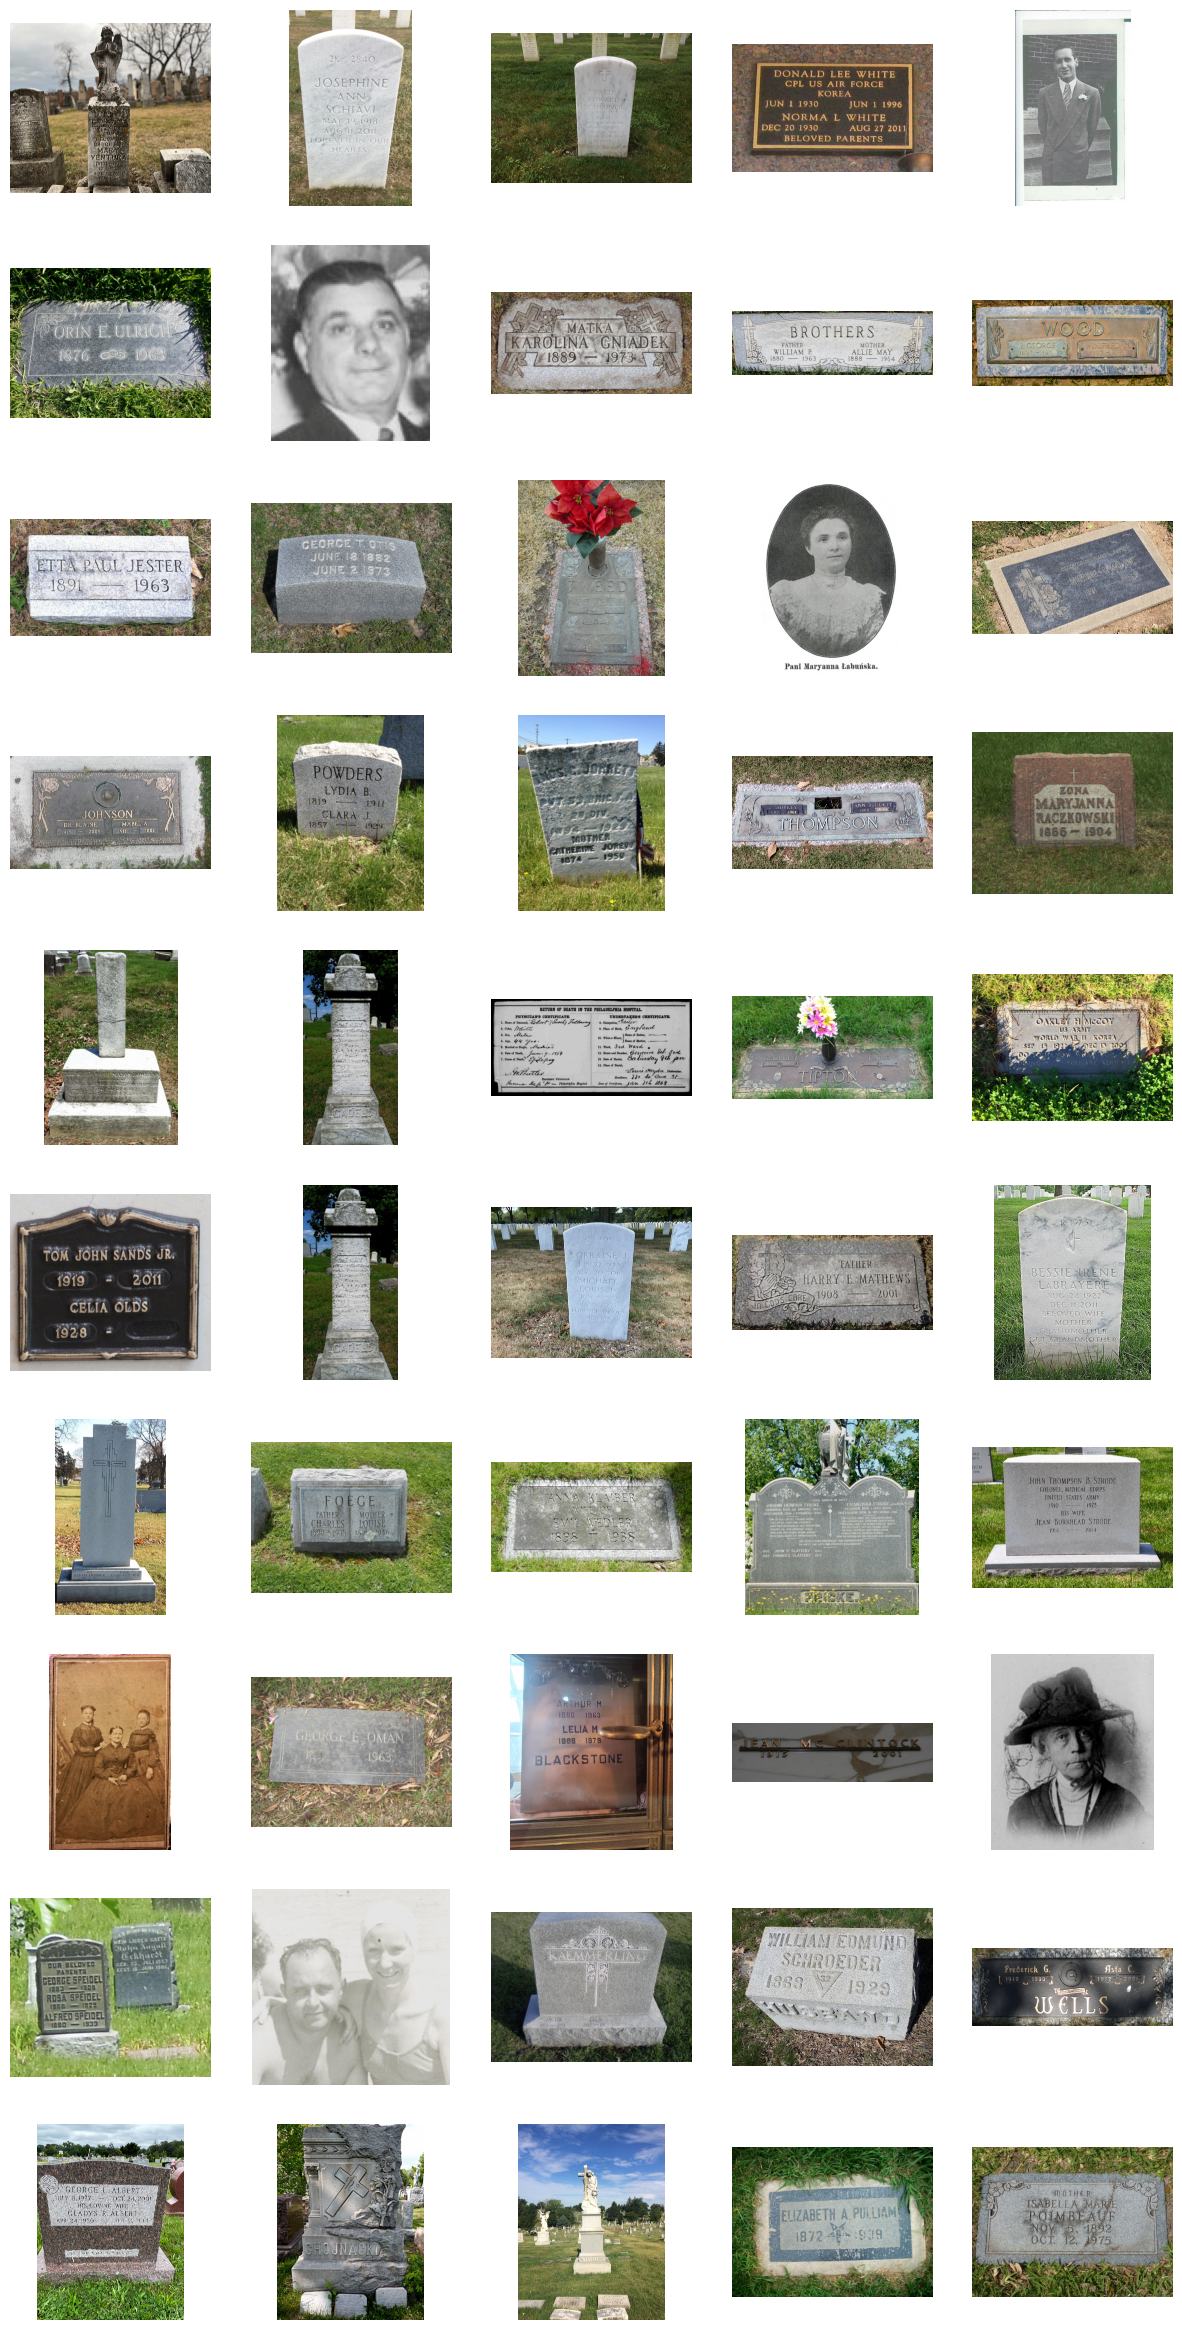

In [9]:
num_images = 50
num_cols = 5

num_rows = math.ceil(num_images/num_cols)
layout = (num_rows, num_cols)
fig, axes = plt.subplots(*layout, figsize=(15, 3 * num_rows))
for i, (image,) in enumerate(dataset):
    if i >= num_images:
        break
    ax = axes[i // layout[1], i % layout[1]]
    ax.imshow(image)
    ax.axis('off')